In [1]:
import joblib

from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import linear_model

from data import load_train_test_sets
from model import evaluate_model, create_pipeline
%matplotlib inline

## Define y_target and split train/test dataset

In [2]:
X_train, y_train, X_test, y_test = load_train_test_sets()

Proportion of popular books in the dataset: 0.07
75122


## Fit and Evaluation functions

We want to maximise for precision, given that a False Positive may be too costly for us.

## Model training and evaluation
### DummyModel

In [3]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train)
print(evaluate_model(dummy_classifier,
                     X_test=X_test,
                     y_test=y_test))

ValueError: Found input variables with inconsistent numbers of samples: [958623, 106514]

### Logistic Regression

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     98841
        True       0.00      0.00      0.00      7673

    accuracy                           0.93    106514
   macro avg       0.46      0.50      0.48    106514
weighted avg       0.86      0.93      0.89    106514



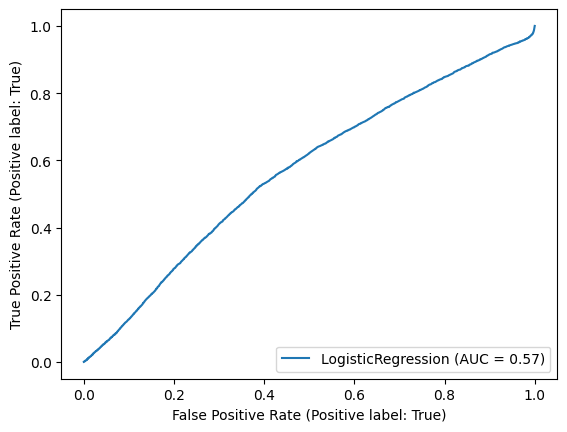

In [8]:
lr = linear_model.LogisticRegression()
lr.fit(X_train[['PublishYear', 'PagesNumber']], y_train)
evaluate_model(lr,
                     X_test=X_test[['PublishYear', 'PagesNumber']],
                     y_test=y_test)

## CountVectorizer

Let's introduce Scikit Learn Pipelines

In [11]:
model = create_pipeline()
model.fit(X_train.head(10000), y_train.head(10000))

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('description_bow',
                                                  CountVectorizer(max_df=0.05,
                                                                  min_df=50,
                                                                  stop_words={'english'}),
                                                  'Description'),
                                                 ('title_bow',
                                                  CountVectorizer(max_df=0.05,
                                                                  min_df=50,
                                                                  stop_words={'english'}),
                                                  'Name')])),
                ('svd', TruncatedSVD(n_components=50)),
                ('classifier', LogisticRegression(random_state=42))])

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     98841
        True       0.40      0.04      0.07      7673

    accuracy                           0.93    106514
   macro avg       0.67      0.52      0.52    106514
weighted avg       0.89      0.93      0.90    106514



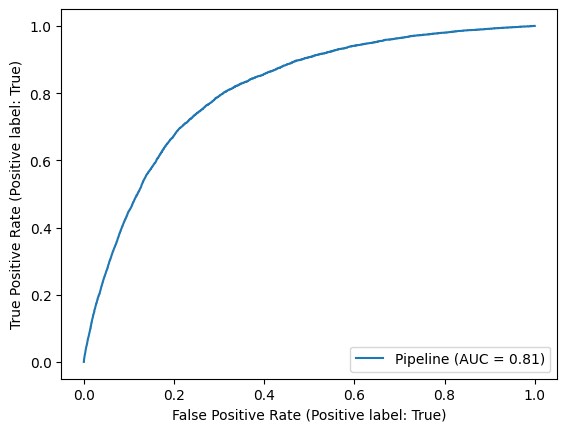

In [12]:
evaluate_model(model, X_test=X_test, y_test=y_test)

### Introducing GridsearchCV to explore hyperparameters

In [15]:
params = {
    'column_transformer__title_bow__min_df': (100, 500),
    'column_transformer__title_bow__max_df': (0.05, 0.1),
    'column_transformer__description_bow__min_df': (100, 500),
    'column_transformer__description_bow__max_df': (0.05, 0.1),
}

random_search = RandomizedSearchCV(model, params, scoring='precision', n_jobs=-1, verbose=1)
random_search.fit(X_train.head(20000), y_train.head(20000))


random_search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.41020171200949235

In [16]:
random_search.best_params_

{'column_transformer__title_bow__min_df': 500,
 'column_transformer__title_bow__max_df': 0.1,
 'column_transformer__description_bow__min_df': 500,
 'column_transformer__description_bow__max_df': 0.05}

In [32]:
final_model = create_pipeline(params=random_search.best_params_)

In [33]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('description_bow',
                                                  CountVectorizer(max_df=0.05,
                                                                  min_df=500,
                                                                  stop_words={'english'}),
                                                  'Description'),
                                                 ('title_bow',
                                                  CountVectorizer(max_df=0.1,
                                                                  min_df=500,
                                                                  stop_words={'english'}),
                                                  'Name')])),
                ('svd', TruncatedSVD(n_components=50)),
                ('classifier', LogisticRegression(random_state=42))])

              precision    recall  f1-score   support

       False       0.93      0.99      0.96     98841
        True       0.42      0.05      0.09      7673

    accuracy                           0.93    106514
   macro avg       0.68      0.52      0.53    106514
weighted avg       0.89      0.93      0.90    106514



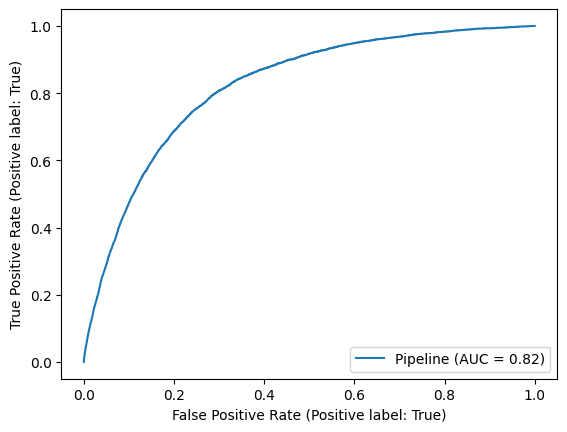

In [34]:
evaluate_model(final_model, X_test, y_test)

In [39]:
joblib.dump(final_model, '../models/final_model.clf')

['../models/final_model.clf']